In [163]:
import random
from datetime import datetime as dt
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
from scipy.special import expit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.utils import resample
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

# Loading and exploring data

In [19]:
# Loading response measures data
measures_df = pd.read_csv("2_ecdc/country_response_measures.csv")
measures_df.date_start = pd.to_datetime(measures_df.date_start)
measures_df.date_end = pd.to_datetime(measures_df.date_end)

measures_df.date_start = measures_df.date_start.fillna(pd.to_datetime('2022-01-01'))
measures_df.date_end = measures_df.date_end.fillna(pd.to_datetime('2022-01-01'))

In [20]:
measures_df.head()

,Country,Response_measure,date_start,date_end
0,Austria,AdaptationOfWorkplace,2020-03-10,2022-01-01
1,Austria,BanOnAllEvents,2020-11-03,2022-01-01
2,Austria,ClosDaycare,2020-03-16,2020-05-04
3,Austria,ClosDaycarePartial,2020-11-17,2020-12-07
4,Austria,ClosHigh,2020-03-16,2020-09-30


In [21]:
measures = measures_df.Response_measure.unique()

In [178]:
measures

array(['AdaptationOfWorkplace', 'BanOnAllEvents', 'ClosDaycare',
       'ClosDaycarePartial', 'ClosHigh', 'ClosPrim', 'ClosPrimPartial',
       'ClosPubAny', 'ClosPubAnyPartial', 'ClosSec', 'ClosSecPartial',
       'EntertainmentVenues', 'GymsSportsCentres',
       'HotelsOtherAccommodation', 'IndoorOver100', 'IndoorOver1000',
       'MasksMandatoryAllSpaces', 'MasksMandatoryClosedSpaces',
       'MasksMandatoryClosedSpacesPartial',
       'MasksVoluntaryClosedSpacesPartial', 'MassGather50',
       'MassGatherAll', 'NonEssentialShops', 'NonEssentialShopsPartial',
       'OutdoorOver1000', 'OutdoorOver50', 'OutdoorOver500',
       'PlaceOfWorship', 'PlaceOfWorshipPartial',
       'PrivateGatheringRestrictions', 'RestaurantsCafes', 'SocialCircle',
       'StayHomeGen', 'StayHomeOrder', 'StayHomeOrderPartial',
       'Teleworking', 'EntertainmentVenuesPartial',
       'GymsSportsCentresPartial', 'IndoorOver500',
       'MasksVoluntaryAllSpaces', 'MasksVoluntaryAllSpacesPartial',
       'R

In [22]:
# Loading covid data
owid = pd.read_csv("1_owid/owid-covid-data.csv")
owid.date = pd.to_datetime(owid.date)

In [23]:
owid.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,total_vaccinations_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,0.026,0.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


In [176]:
owid.date.max()

Timestamp('2021-01-04 00:00:00')

In [175]:
positive_rate = owid[owid.location=='Italy'].positive_rate
new_cases = owid[owid.location=='Italy'].new_cases_smoothed
rep_rate = owid[owid.location=='Italy'].reproduction_rate
var = [positive_rate, new_cases, rep_rate]
names = ["positive_rate", "new_cases", "rep_rate"]

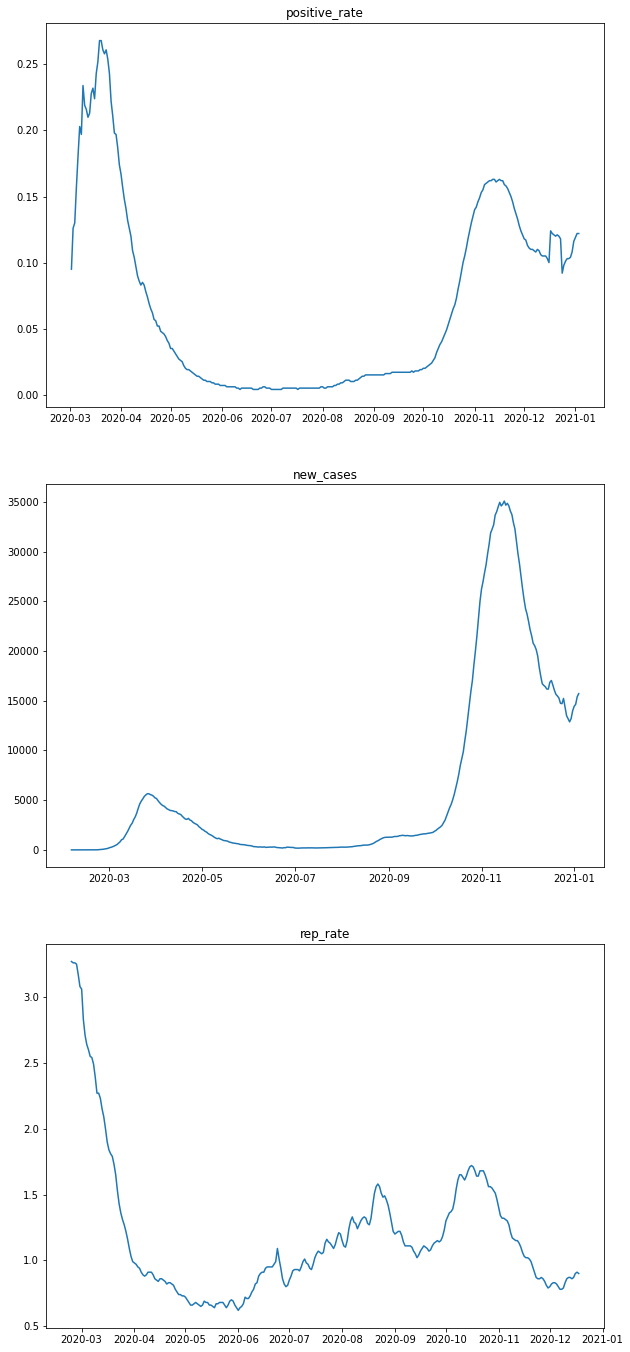

In [25]:
N = len(var)
dates = owid[owid.location=='Italy'].date
f, axes = plt.subplots(N,1,figsize=(10,8*N))
ax = axes.flatten()
for i, x in enumerate(var):
    ax[i].plot(dates, x, '-')
    ax[i].set_title(names[i])

**Reproduction rate or new cases make most sense as the response variable**

# Data Wrangling & Feature Engineering

In [26]:
countries = measures_df.Country.unique()
eu_owid = owid[owid.location.isin(countries)]
eu_owid = eu_owid.reset_index(drop=True)

In [27]:
cols = list(measures)

In [28]:
for measure in measures:
    eu_owid[measure] = np.nan

In [29]:
for index, row in eu_owid.iterrows():
    for measure in measures:
        start_date = measures_df[(measures_df.Country == row['location'])&(measures_df.Response_measure==measure)].date_start.reset_index(drop=True)
        end_date = measures_df[(measures_df.Country == row['location'])&(measures_df.Response_measure==measure)].date_end.reset_index(drop=True)
        try:
            for i in range(len(start_date)):
                if start_date[i] <= row['date'] and end_date[i] >= row['date']:
                    eu_owid.loc[index, measure] = 1
                    break
                else:
                    eu_owid.loc[index, measure] = 0
        except ValueError:
            eu_owid.loc[index, measure] = 0

<AxesSubplot:>

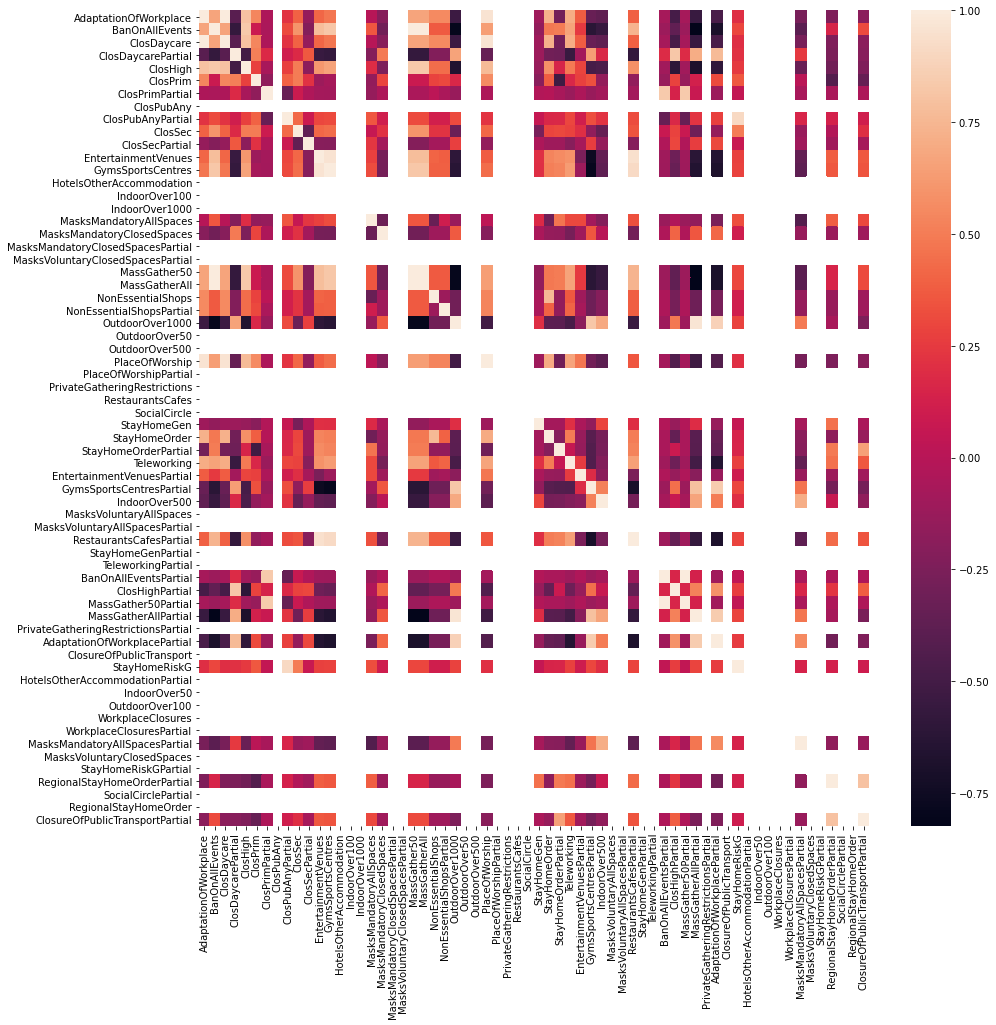

In [101]:
f, ax = plt.subplots(figsize=(15,15))
sns.heatmap(eu_owid[eu_owid.location=="Italy"][cols].corr(), ax = ax)

In [110]:
# Selecting response measures to model based on correlation maps
responses = ["StayHomeOrder","StayHomeGen","PrivateGatheringRestrictions", "ClosSec", "MassGatherAll",
            "ClosPubAny","MasksVoluntaryAllSpaces", "MasksVoluntaryClosedSpaces","MasksMandatoryAllSpaces", 
             "MasksMandatoryClosedSpaces", "Teleworking"]

<AxesSubplot:>

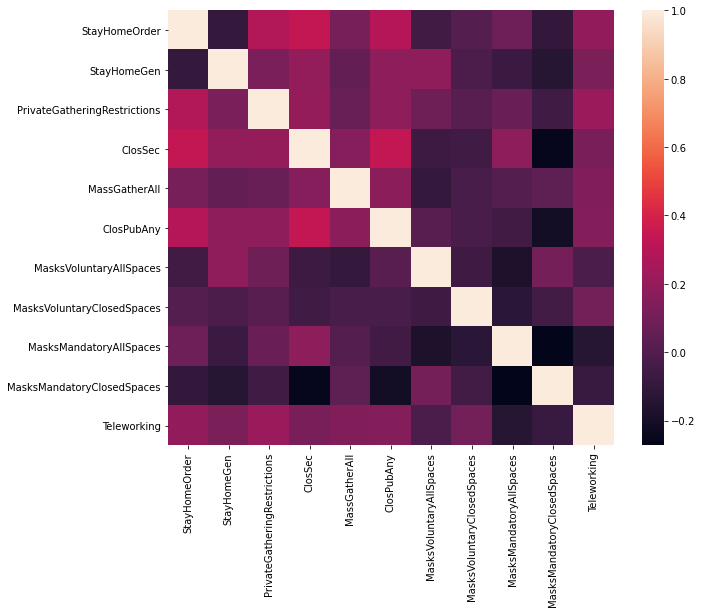

In [179]:
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(eu_owid[responses].corr(), ax = ax)

# Modeling

First, we will try to see if there is a particular distribution behind a coefficient fitting multiple linear regressions.

In [166]:
beta_stayhomegen = []
beta_stayhome = []
beta3 = []
for country in countries:
    for i in range(50):
        data_ = eu_owid[eu_owid.location==country].dropna(subset=["reproduction_rate"])
        data = resample(data_)
        X = data[responses]
        y = data.reproduction_rate
        lreg = LinearRegression().fit(X, y)
        beta_stayhomegen.append(lreg.coef_[5])
        beta_stayhome.append(lreg.coef_[3])
        beta3.append(lreg.coef_[2])

Text(0.5, 1.0, 'Distribution of MassGatherAll Coefficient')

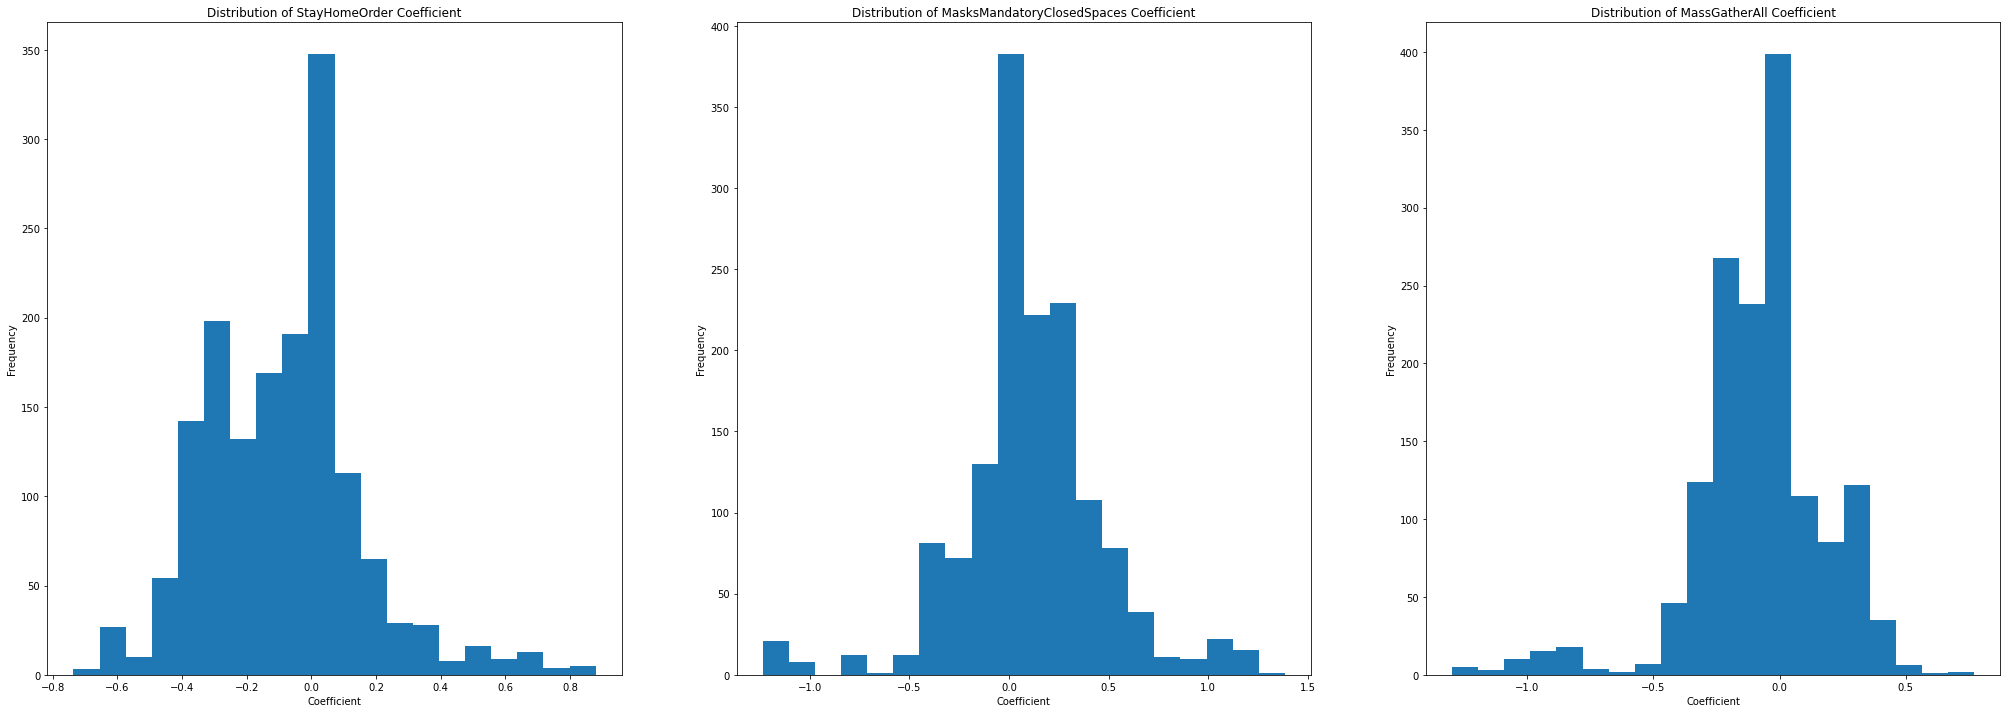

In [180]:
beta_stayhome = np.array(beta_stayhome)
beta_stayhome = beta_stayhome[np.abs(beta_stayhome)<=30]
beta_stayhomegen = np.array(beta_stayhomegen)
beta_stayhomegen = beta_stayhomegen[np.abs(beta_stayhomegen)<=30]
beta3 = np.array(beta3)
beta3 = beta3[np.abs(beta3)<=30]
f, ax = plt.subplots(1, 3, figsize=(35,12))
ax[0].hist(beta_stayhome, bins=20)
ax[0].set_xlabel("Coefficient")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Distribution of StayHomeOrder Coefficient")
ax[1].hist(beta_stayhomegen, bins=20)
ax[1].set_xlabel("Coefficient")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Distribution of MasksMandatoryClosedSpaces Coefficient")
ax[2].hist(beta3, bins=20)
ax[2].set_xlabel("Coefficient")
ax[2].set_ylabel("Frequency")
ax[2].set_title("Distribution of MassGatherAll Coefficient")

Normal distributions in the coefficients seem like an okay assumption

The prior distribution assumptions that we are going to make in this analysis are:

$$\mu_r=\beta_{0j}+\beta_{1j}*measure_1+...+\beta_{ij}*measure_i$$

$$\frac{1}{\sigma_r^2} \sim {Gamma}(0.1,0.1)$$

$$\beta_{0j}\sim  \mathcal{N}(\mu_0,\,\sigma_0^{2})\; {, with} \;\; \frac{1}{\sigma^2_0} \sim {Gamma}(0.1,0.1)\ {and} \;\; \mu_0 \sim \mathcal{N}(0,\,100^2)$$

$$\beta_{1j} \sim N(\mu_1,\sigma_1^2)\; {, with} \;\; \frac{1}{\sigma^2_1} \sim {Gamma}(0.1,0.1)\ {and} \;\; \mu_1 \sim \mathcal{N}(0,\,100^2)$$
$$.$$
$$.$$
$$.$$
$$\beta_{ij} \sim N(\mu_i,\sigma_i^2)\; {, with} \;\; \frac{1}{\sigma^2_i} \sim {Gamma}(0.1,0.1)\ {and} \;\; \mu_i \sim \mathcal{N}(0,\,100^2)$$

$$R \sim \mathcal{N}(\mu_r, \sigma_r^2)$$

Where $R$ is the response variable, reproduction rate, $i$ is the index of the response measure taken and $j$ is the index of the country.

In [106]:
countries_idx = {'Austria':0, 'Belgium':1, 'Bulgaria':2, 'Croatia':3, 'Cyprus':4, 'Czechia':5,
       'Denmark':6, 'Estonia':7, 'Finland':8, 'France':9, 'Germany':10, 'Greece':11,
       'Hungary':12, 'Iceland':13, 'Ireland':14, 'Italy':15, 'Latvia':16,
       'Liechtenstein':17, 'Lithuania':18, 'Luxembourg':19, 'Malta':20, 'Netherlands':21,
       'Norway':22, 'Poland':23, 'Portugal':24, 'Romania':25, 'Slovakia':26, 'Slovenia':27,
       'Spain':28, 'Sweden':29, 'Switzerland':30, 'United Kingdom':31}

In [107]:
eu_owid["country_idx"] = eu_owid.location.apply(lambda x: countries_idx[x])

In [124]:
J = len(countries)
eu_owid = eu_owid.dropna(subset=["reproduction_rate"])
country_idx = eu_owid.country_idx.values

In [137]:
eu_owid, eu_owid_test = train_test_split(eu_owid, test_size=0.2)

In [142]:
eu_owid.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,total_vaccinations_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,AdaptationOfWorkplace,BanOnAllEvents,ClosDaycare,ClosDaycarePartial,ClosHigh,ClosPrim,ClosPrimPartial,ClosPubAny,ClosPubAnyPartial,ClosSec,ClosSecPartial,EntertainmentVenues,GymsSportsCentres,HotelsOtherAccommodation,IndoorOver100,IndoorOver1000,MasksMandatoryAllSpaces,MasksMandatoryClosedSpaces,MasksMandatoryClosedSpacesPartial,MasksVoluntaryClosedSpacesPartial,MassGather50,MassGatherAll,NonEssentialShops,NonEssentialShopsPartial,OutdoorOver1000,OutdoorOver50,OutdoorOver500,PlaceOfWorship,PlaceOfWorshipPartial,PrivateGatheringRestrictions,RestaurantsCafes,SocialCircle,StayHomeGen,StayHomeOrder,StayHomeOrderPartial,Teleworking,EntertainmentVenuesPartial,GymsSportsCentresPartial,IndoorOver500,MasksVoluntaryAllSpaces,MasksVoluntaryAllSpacesPartial,RestaurantsCafesPartial,StayHomeGenPartial,TeleworkingPartial,BanOnAllEventsPartial,ClosHighPartial,MassGather50Partial,MassGatherAllPartial,PrivateGatheringRestrictionsPartial,AdaptationOfWorkplacePartial,ClosureOfPublicTransport,StayHomeRiskG,HotelsOtherAccommodationPartial,IndoorOver50,OutdoorOver100,WorkplaceClosures,WorkplaceClosuresPartial,MasksMandatoryAllSpacesPartial,MasksVoluntaryClosedSpaces,StayHomeRiskGPartial,RegionalStayHomeOrderPartial,SocialCirclePartial,RegionalStayHomeOrder,ClosureOfPublicTransportPartial,country_idx
5720,LIE,Europe,Liechtenstein,2020-09-29,118.0,1.0,0.429,1.0,0.0,0.000,3094.108,26.221,11.238,26.221,0.000,0.000,1.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38137.0,237.012,NaN,NaN,NaN,NaN,NaN,NaN,7.77,NaN,NaN,NaN,2.397,82.49,0.916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17
3009,FRA,Europe,France,2020-04-27,165966.0,3686.0,1652.000,23267.0,437.0,432.286,2542.624,56.470,25.309,356.454,6.695,6.623,0.69,4526.0,69.339,27954.0,428.259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.96,65273512.0,122.578,42.0,19.718,13.079,38605.671,NaN,86.060,4.77,30.1,35.6,NaN,5.980,82.66,0.901,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
5934,LTU,Europe,Lithuania,2020-06-22,1801.0,3.0,4.000,76.0,0.0,0.000,661.575,1.102,1.469,27.918,0.000,0.000,0.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3142.0,380662.0,139.831,1.154,3983.0,1.463,0.001,995.8,tests performed,NaN,NaN,34.26,2722291.0,45.135,43.5,19.002,13.778,29524.265,0.7,342.989,3.67,21.3,38.0,NaN,6.560,75.93,0.858,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18
6863,NLD,Europe,Netherlands,2020

In [126]:
with pm.Model() as hierarchical_model:
    # Intercept
    mu0 = pm.Normal("mu0", mu=0, sigma=100)
    s0 = pm.Gamma("s0", alpha=0.1, beta=0.1)
    b0j = pm.Normal("b0j", mu=mu0, tau=s0, shape=J)
    
    # StayHomeOrder
    mu1 = pm.Normal("mu1", mu=0, sigma=100)
    s1 = pm.Gamma("s1", alpha=0.1, beta=0.1)
    b1j = pm.Normal("b1j", mu=mu1, tau=s1, shape=J)
    
    # StayHomeGen
    mu2 = pm.Normal("mu2", mu=0, sigma=100)
    s2 = pm.Gamma("s2", alpha=0.1, beta=0.1)
    b2j = pm.Normal("b2j", mu=mu2, tau=s2, shape=J)
    
    # PrivateGatheringRestrictions
    mu3 = pm.Normal("mu3", mu=0, sigma=100)
    s3 = pm.Gamma("s3", alpha=0.1, beta=0.1)
    b3j = pm.Normal("b3j", mu=mu3, tau=s3, shape=J)
    
    # ClosSec
    mu4 = pm.Normal("mu4", mu=0, sigma=100)
    s4 = pm.Gamma("s4", alpha=0.1, beta=0.1)
    b4j = pm.Normal("b4j", mu=mu4, tau=s4, shape=J)
    
    # MassGatherAll
    mu5 = pm.Normal("mu5", mu=0, sigma=100)
    s5 = pm.Gamma("s5", alpha=0.1, beta=0.1)
    b5j = pm.Normal("b5j", mu=mu5, tau=s5, shape=J)
    
    # ClosPubAny
    mu6 = pm.Normal("mu6", mu=0, sigma=100)
    s6 = pm.Gamma("s6", alpha=0.1, beta=0.1)
    b6j = pm.Normal("b6j", mu=mu6, tau=s6, shape=J)
    
    # MasksVoluntaryAllSpaces
    mu7 = pm.Normal("mu7", mu=0, sigma=100)
    s7 = pm.Gamma("s7", alpha=0.1, beta=0.1)
    b7j = pm.Normal("b7j", mu=mu7, tau=s7, shape=J)
    
    # MasksVoluntaryClosedSpaces
    mu8 = pm.Normal("mu8", mu=0, sigma=100)
    s8 = pm.Gamma("s8", alpha=0.1, beta=0.1)
    b8j = pm.Normal("b8j", mu=mu8, tau=s8, shape=J)
    
    # MasksMandatoryAllSpaces
    mu9 = pm.Normal("mu9", mu=0, sigma=100)
    s9 = pm.Gamma("s9", alpha=0.1, beta=0.1)
    b9j = pm.Normal("b9j", mu=mu9, tau=s9, shape=J)
    
    # MasksMandatoryClosedSpaces
    mu10 = pm.Normal("mu10", mu=0, sigma=100)
    s10 = pm.Gamma("s10", alpha=0.1, beta=0.1)
    b10j = pm.Normal("b10j", mu=mu10, tau=s10, shape=J)
    
    # Teleworking
    mu11 = pm.Normal("mu11", mu=0, sigma=100)
    s11 = pm.Gamma("s11", alpha=0.1, beta=0.1)
    b11j = pm.Normal("b11j", mu=mu11, tau=s11, shape=J)
    
    mur = (b0j[country_idx] + b1j[country_idx]*eu_owid.StayHomeOrder.values + b2j[country_idx]*eu_owid.StayHomeGen.values
           + b3j[country_idx]*eu_owid.PrivateGatheringRestrictions.values + b4j[country_idx]*eu_owid.ClosSec.values
           + b5j[country_idx]*eu_owid.MassGatherAll.values + b6j[country_idx]*eu_owid.ClosPubAny.values
           + b7j[country_idx]*eu_owid.MasksVoluntaryAllSpaces.values + b8j[country_idx]*eu_owid.MasksVoluntaryClosedSpaces.values
           + b9j[country_idx]*eu_owid.MasksMandatoryAllSpaces.values + b10j[country_idx]*eu_owid.MasksMandatoryClosedSpaces.values
           + b11j[country_idx]*eu_owid.Teleworking.values)
    
    sr = pm.Gamma("sr", alpha=0.1, beta=0.1)
    
    Y_obs = pm.Normal('Y_obs', mu=mur, tau=sr, observed=eu_owid['reproduction_rate'])

In [128]:
with hierarchical_model:
    trace = pm.sample(10000, tune=5000, target_accept=.95)

/Users/diegozertuche/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sr, b11j, s11, mu11, b10j, s10, mu10, b9j, s9, mu9, b8j, s8, mu8, b7j, s7, mu7, b6j, s6, mu6, b5j, s5, mu5, b4j, s4, mu4, b3j, s3, mu3, b2j, s2, mu2, b1j, s1, mu1, b0j, s0, mu0]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 24522 seconds.
The number of effective samples is smaller than 10% for some parameters.


## Getting posterior statistics

/Users/diegozertuche/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'b1j'}>,
        <AxesSubplot:title={'center':'b1j'}>],
       [<AxesSubplot:title={'center':'mu1'}>,
        <AxesSubplot:title={'center':'mu1'}>]], dtype=object)

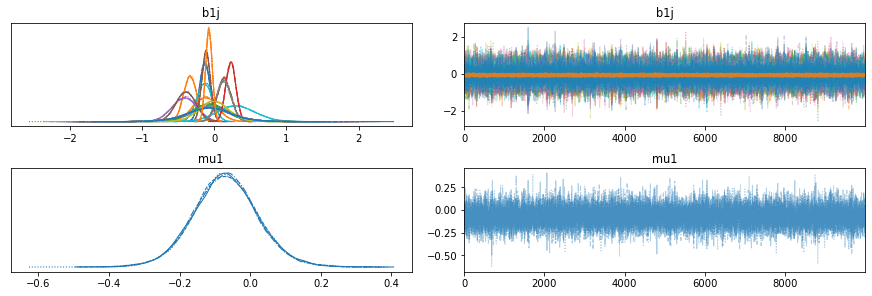

In [181]:
az.plot_trace(trace, var_names=["b1j", "mu1"])

/Users/diegozertuche/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/diegozertuche/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/arviz/plots/traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (37), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'sr'}>,
        <AxesSubplot:title={'center':'sr'}>],
       [<AxesSubplot:title={'center':'b11j'}>,
        <AxesSubplot:title={'center':'b11j'}>],
       [<AxesSubplot:title={'center':'s11'}>,
        <AxesSubplot:title={'center':'s11'}>],
       [<AxesSubplot:title={'center':'mu11'}>,
        <AxesSubplot:title={'center':'mu11'}>],
       [<AxesSubplot:title={'center':'b10j'}>,
        <AxesSubplot:title={'center':'b10j'}>],
       [<AxesSubplot:title={'center':'s10'}>,
        <AxesSubplot:title={'center':'s10'}>],
       [<AxesSubplot:title={'center':'mu10'}>,
        <AxesSubplot:title={'center':'mu10'}>],
       [<AxesSubplot:title={'center':'b9j'}>,
        <AxesSubplot:title={'center':'b9j'}>],
       [<AxesSubplot:title={'center':'s9'}>,
        <AxesSubplot:title={'center':'s9'}>],
       [<AxesSubplot:title={'center':'mu9'}>,
        <AxesSubplot:title={'center':'mu9'}>],
       [<AxesSubplot:title={'center':'b8j'}>,
        <AxesSubplot

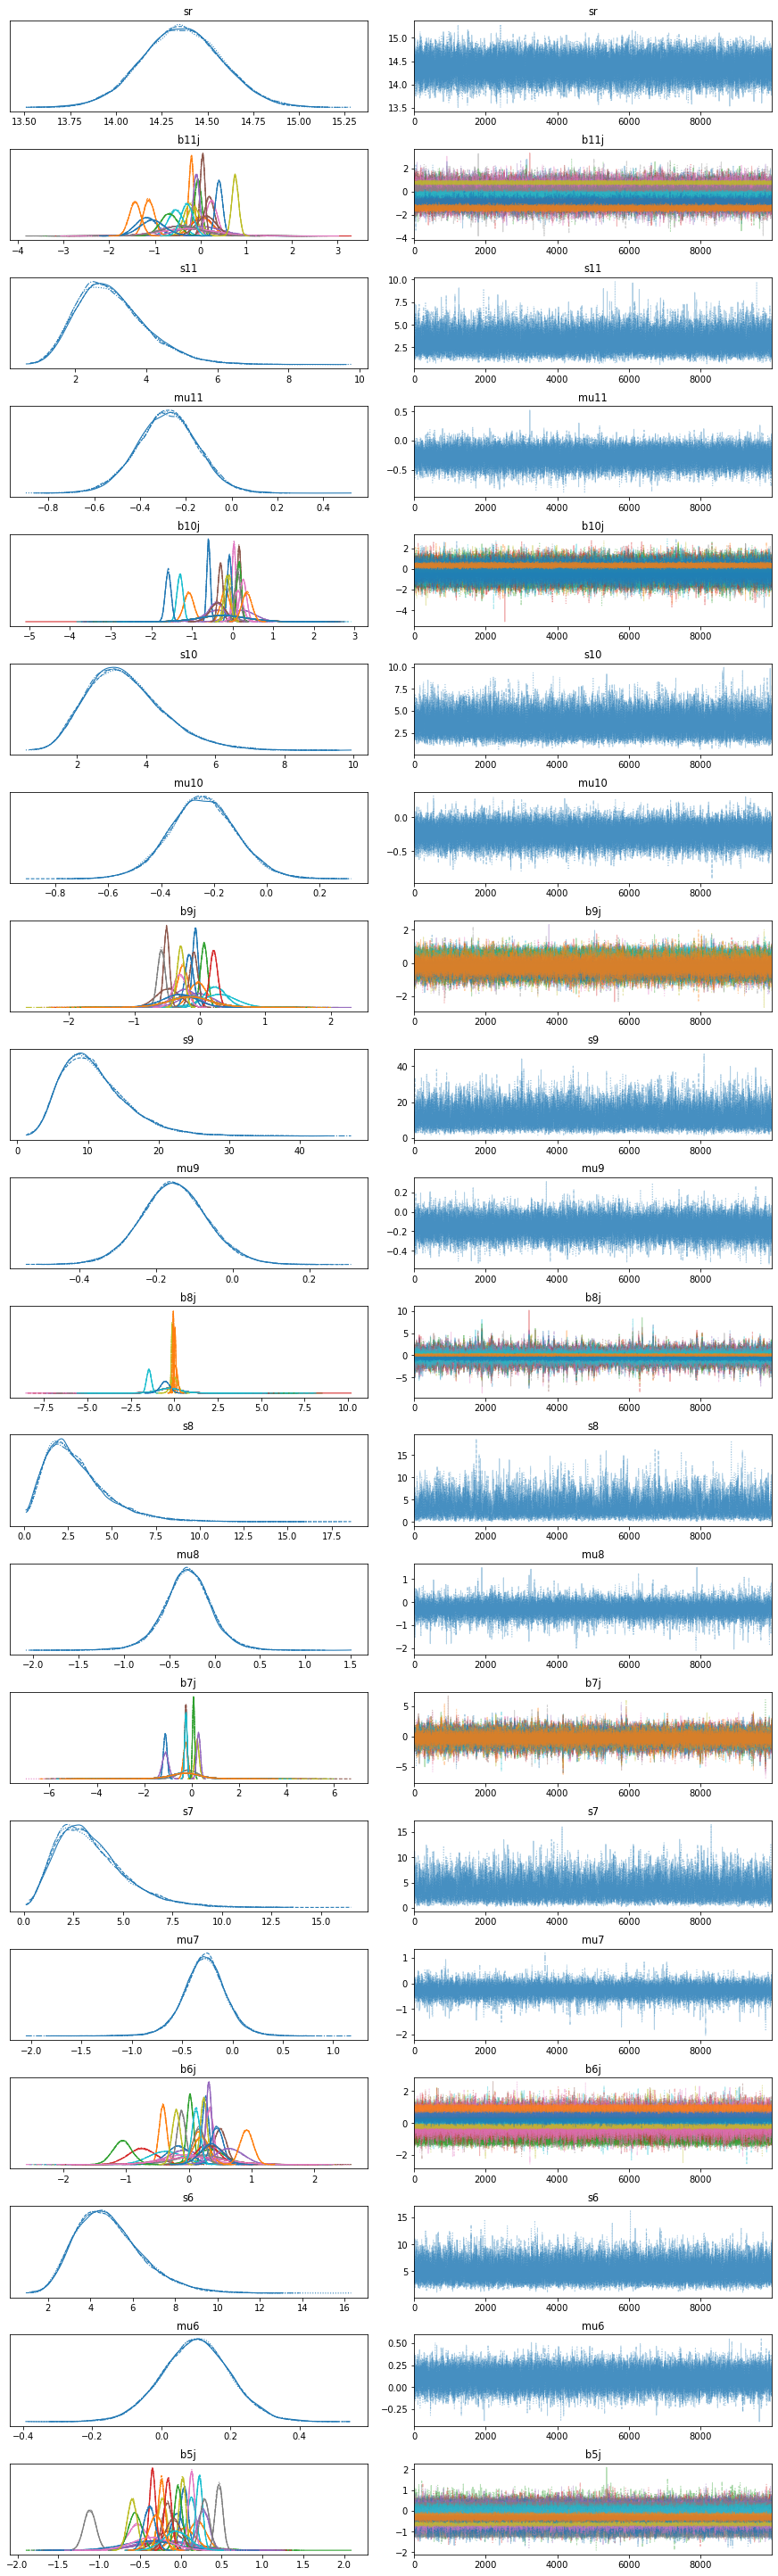

In [129]:
az.plot_trace(trace, var_names=["sr", "b11j", "s11", "mu11", "b10j", "s10", "mu10", "b9j", "s9", "mu9", "b8j", 
                                     "s8", "mu8", "b7j", "s7", "mu7", "b6j", "s6", "mu6", "b5j", "s5", "mu5", "b4j", 
                                     "s4", "mu4", "b3j", "s3", "mu3", "b2j", "s2", "mu2", "b1j", "s1", "mu1", "b0j", 
                                     "s0", "mu0"])

In [130]:
summ = az.summary(trace, var_names=["sr", "b11j", "s11", "mu11", "b10j", "s10", "mu10", "b9j", "s9", "mu9", "b8j", 
                                     "s8", "mu8", "b7j", "s7", "mu7", "b6j", "s6", "mu6", "b5j", "s5", "mu5", "b4j", 
                                     "s4", "mu4", "b3j", "s3", "mu3", "b2j", "s2", "mu2", "b1j", "s1", "mu1", "b0j", 
                                     "s0", "mu0"])

/Users/diegozertuche/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [138]:
summ.head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sr,14.361,0.219,13.937,14.766,0.001,0.001,55870.0,55870.0,55832.0,30304.0,1.0
b11j[0],-1.193,0.235,-1.638,-0.754,0.001,0.001,34168.0,32965.0,34226.0,27558.0,1.0
b11j[1],-0.202,0.056,-0.308,-0.098,0.000,0.000,49167.0,45976.0,49189.0,31644.0,1.0
b11j[2],-0.056,0.077,-0.203,0.084,0.000,0.000,61386.0,27407.0,61373.0,30562.0,1.0
b11j[3],0.034,0.229,-0.405,0.452,0.001,0.001,34520.0,19455.0,34525.0,28639.0,1.0


Yay! Our MCMC samplers converged after running for 7 hours!

## Testing model fit

In [141]:
trace['b3j'].mean(axis=0)

array([ 0.30950869, -0.18572158, -0.03246942, -0.11728269, -0.29159797,
       -0.50208457, -0.01838184,  0.04245691, -0.18811059, -0.18845014,
        0.0469648 , -0.11000965, -0.18550217, -0.16652146, -0.32138859,
       -0.19006139, -0.06344252, -0.38145978,  0.16779661, -0.15929883,
       -0.18842634, -0.22665221, -0.71917211, -0.91415566, -1.00577446,
       -0.19758534, -0.05734668, -0.18403233,  0.2334869 ,  0.1159435 ,
       -0.27262544, -0.0799419 ])

In [143]:
def f_c1(df_):
    country_idx_ = df_.country_idx
    b0jm = trace['b0j'].mean(axis=0)
    b1jm = trace['b1j'].mean(axis=0)
    b2jm = trace['b2j'].mean(axis=0)
    b3jm = trace['b3j'].mean(axis=0)
    b4jm = trace['b4j'].mean(axis=0)
    b5jm = trace['b5j'].mean(axis=0)
    b6jm = trace['b6j'].mean(axis=0)
    b7jm = trace['b7j'].mean(axis=0)
    b8jm = trace['b8j'].mean(axis=0)
    b9jm = trace['b9j'].mean(axis=0)
    b10jm = trace['b10j'].mean(axis=0)
    b11jm = trace['b11j'].mean(axis=0)
    R = (b0jm[country_idx_] + b1jm[country_idx_]*df_.StayHomeOrder.values + b2jm[country_idx_]*df_.StayHomeGen.values
           + b3jm[country_idx_]*df_.PrivateGatheringRestrictions.values + b4jm[country_idx_]*df_.ClosSec.values
           + b5jm[country_idx_]*df_.MassGatherAll.values + b6jm[country_idx_]*df_.ClosPubAny.values
           + b7jm[country_idx_]*df_.MasksVoluntaryAllSpaces.values + b8jm[country_idx_]*df_.MasksVoluntaryClosedSpaces.values
           + b9jm[country_idx_]*df_.MasksMandatoryAllSpaces.values + b10jm[country_idx_]*df_.MasksMandatoryClosedSpaces.values
           + b11jm[country_idx_]*df_.Teleworking.values)
    return R

In [146]:
y_pred_train = f_c1(eu_owid)
y_pred = f_c1(eu_owid_test)

y_train = eu_owid.reproduction_rate
y = eu_owid_test.reproduction_rate

In [148]:
train_r2 = r2_score(y_train, y_pred_train)
r2 = r2_score(y, y_pred)

In [149]:
r2

0.5446357846931975

We have an r-squared of 0.55 in the test data

# What we actually care about (Distributions of our hyperparameters)

In [161]:
responses

['StayHomeOrder',
 'StayHomeGen',
 'PrivateGatheringRestrictions',
 'ClosSec',
 'MassGatherAll',
 'ClosPubAny',
 'MasksVoluntaryAllSpaces',
 'MasksVoluntaryClosedSpaces',
 'MasksMandatoryAllSpaces',
 'MasksMandatoryClosedSpaces',
 'Teleworking']

In [153]:
summ.loc[["mu0", "mu1", "mu2", "mu3", "mu4", "mu5", "mu6", "mu7", "mu8", "mu9", "mu10", "mu11"]]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu0,1.773,0.126,1.535,2.010,0.001,0.000,41690.0,41667.0,41918.0,28974.0,1.0
mu1,-0.070,0.093,-0.245,0.106,0.001,0.000,22875.0,20618.0,22966.0,24831.0,1.0
mu2,0.098,0.160,-0.209,0.396,0.001,0.001,30236.0,23161.0,30298.0,28404.0,1.0
mu3,-0.188,0.069,-0.317,-0.056,0.000,0.000,40649.0,37001.0,40888.0,28633.0,1.0
mu4,-0.078,0.052,-0.177,0.019,0.000,0.000,41972.0,32568.0,42267.0,28195.0,1.0
mu5,-0.143,0.072,-0.277,-0.006,0.000,0.000,42505.0,37747.0,42656.0,30786.0,1.0
mu6,0.100,0.099,-0.090,0.282,0.000,0.000,39658.0,31562.0,39719.0,30886.0,1.0
mu7,-0.277,0.216,-0.692,0.126,0.002,0.001,18855.0,14358.0,19726.0,19373.0,1.0
mu8,-0.300,0.272,-0.809,0.221,0.002,0.002,14367.0,10324.0,15047.0,14382.0,1.0
mu9,-0.152,0.088,-0.313,0.019,0.001,0.000,26560.0,26560.0,26567.0,26587.0,1.0


The most effective responses seem to be teleworking and MaskMandatoryClosedSpaces. Note that MaskVoluntaryClosedSpaces has a more negative mean, but the standard deviation is greater than MaskMandatoryClosedSpaces, so our uncertainty is greater with the first. In fact we can assert with 94% confidence that the mean of the parameter for MaskMandatoryClosedSpaces is lower than 0.

/Users/diegozertuche/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'mu0'}>,
        <AxesSubplot:title={'center':'mu0'}>],
       [<AxesSubplot:title={'center':'mu1'}>,
        <AxesSubplot:title={'center':'mu1'}>],
       [<AxesSubplot:title={'center':'mu2'}>,
        <AxesSubplot:title={'center':'mu2'}>],
       [<AxesSubplot:title={'center':'mu3'}>,
        <AxesSubplot:title={'center':'mu3'}>],
       [<AxesSubplot:title={'center':'mu4'}>,
        <AxesSubplot:title={'center':'mu4'}>],
       [<AxesSubplot:title={'center':'mu5'}>,
        <AxesSubplot:title={'center':'mu5'}>],
       [<AxesSubplot:title={'center':'mu6'}>,
        <AxesSubplot:title={'center':'mu6'}>],
       [<AxesSubplot:title={'center':'mu7'}>,
        <AxesSubplot:title={'center':'mu7'}>],
       [<AxesSubplot:title={'center':'mu8'}>,
        <AxesSubplot:title={'center':'mu8'}>],
       [<AxesSubplot:title={'center':'mu9'}>,
        <AxesSubplot:title={'center':'mu9'}>],
       [<AxesSubplot:title={'center':'mu10'}>,
        <AxesSubplot:ti

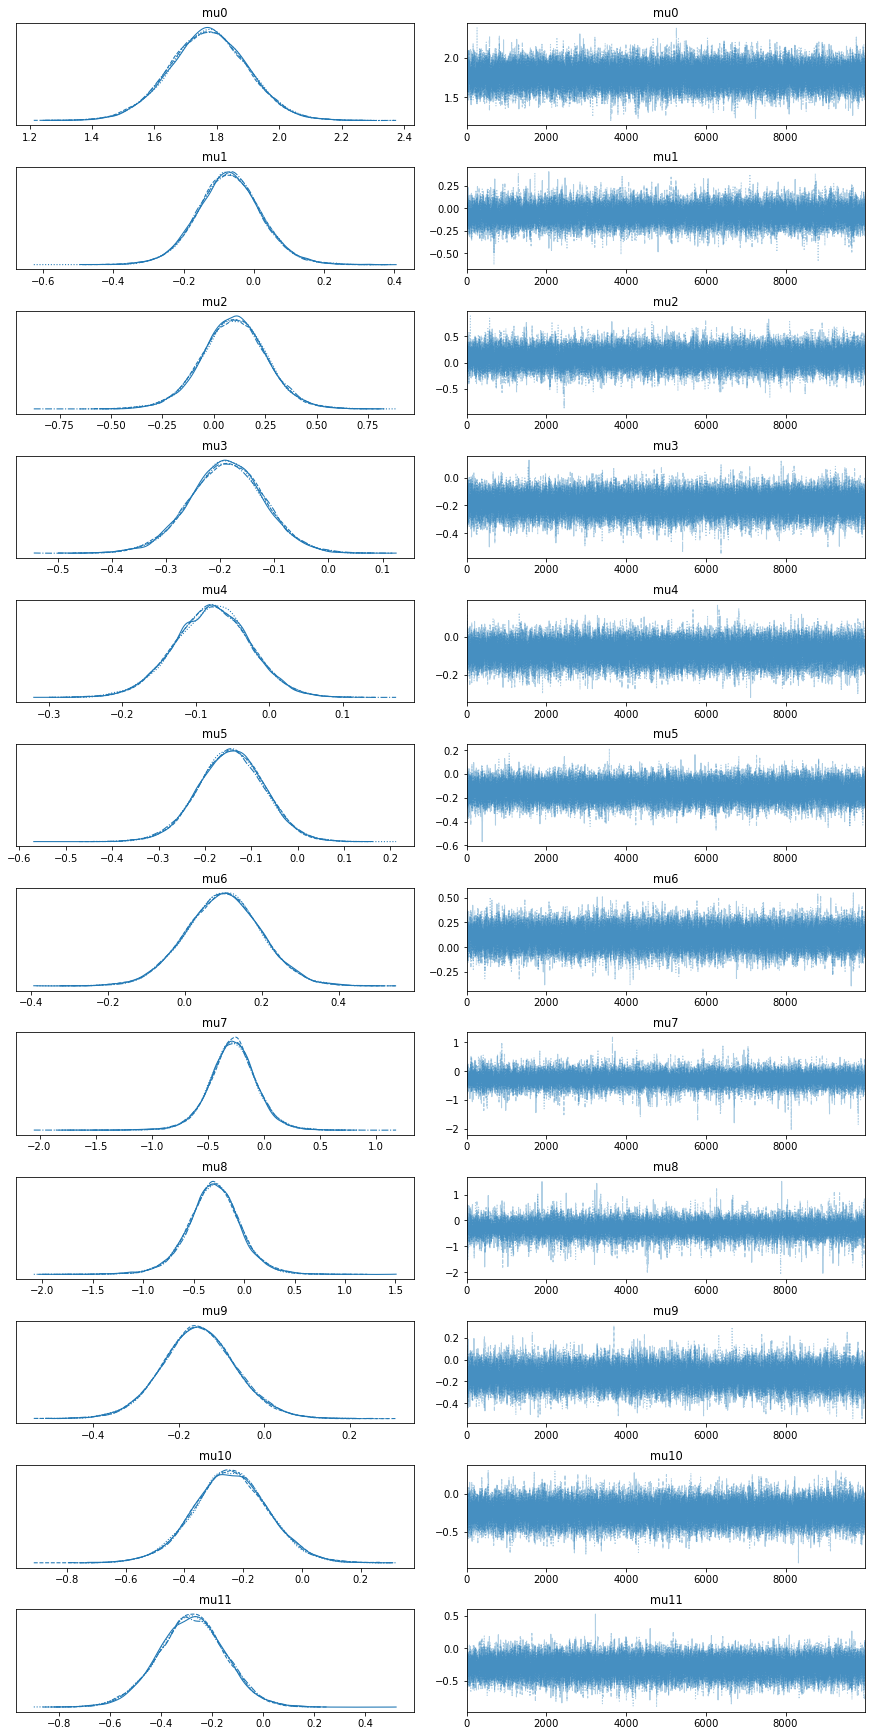

In [156]:
az.plot_trace(trace, var_names=["mu0", "mu1", "mu2", "mu3", "mu4", "mu5", "mu6", "mu7", "mu8", "mu9", "mu10", "mu11"])

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

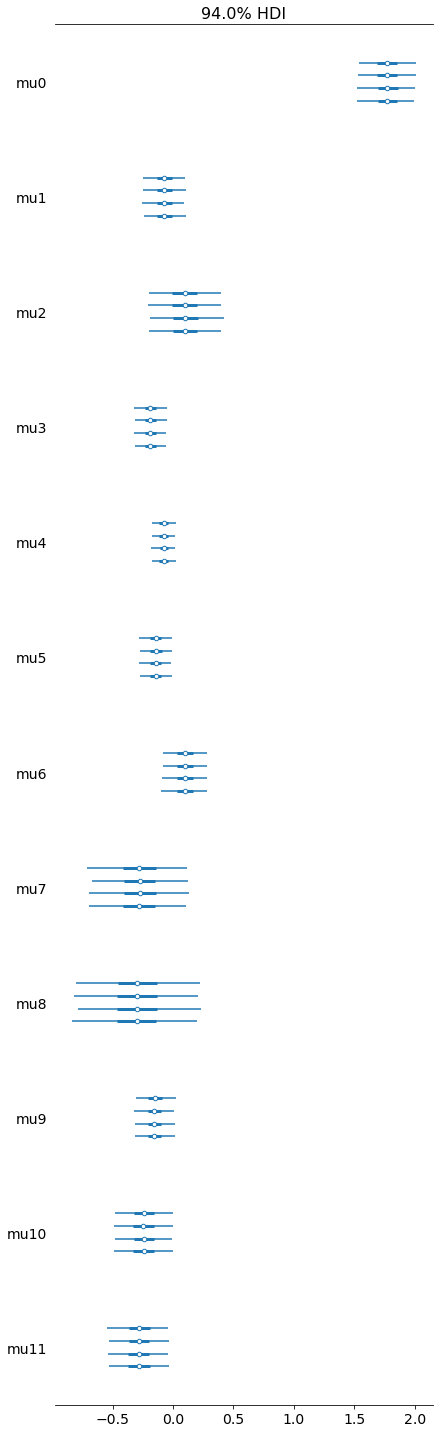

In [159]:
az.plot_forest(trace, var_names=["mu0", "mu1", "mu2", "mu3", "mu4", "mu5", "mu6", "mu7", "mu8", "mu9", "mu10", "mu11"])

In [155]:
summ.loc[["s0", "s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8", "s9", "s10", "s11"]]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
s0,2.586,0.711,1.303,3.901,0.003,0.002,41682.0,40674.0,40760.0,30233.0,1.0
s1,13.411,6.785,2.993,25.663,0.072,0.051,8801.0,8801.0,7643.0,12682.0,1.0
s2,3.212,1.279,1.124,5.655,0.011,0.008,13666.0,13666.0,12485.0,18541.0,1.0
s3,9.223,3.069,3.973,14.989,0.019,0.014,25267.0,25267.0,23625.0,28381.0,1.0
s4,15.923,4.704,7.820,24.846,0.025,0.018,35818.0,35818.0,34670.0,29196.0,1.0
s5,8.020,2.311,3.900,12.309,0.012,0.008,38174.0,38174.0,36616.0,28307.0,1.0
s6,4.887,1.588,2.080,7.785,0.010,0.007,25892.0,25892.0,24515.0,28162.0,1.0
s7,3.383,1.755,0.536,6.563,0.021,0.015,6865.0,6865.0,5950.0,8855.0,1.0
s8,2.989,1.814,0.281,6.241,0.027,0.019,4470.0,4470.0,3589.0,5654.0,1.0
s9,10.954,4.767,3.168,19.668,0.046,0.033,10644.0,10644.0,9597.0,16653.0,1.0


/Users/diegozertuche/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'s0'}>,
        <AxesSubplot:title={'center':'s0'}>],
       [<AxesSubplot:title={'center':'s1'}>,
        <AxesSubplot:title={'center':'s1'}>],
       [<AxesSubplot:title={'center':'s2'}>,
        <AxesSubplot:title={'center':'s2'}>],
       [<AxesSubplot:title={'center':'s3'}>,
        <AxesSubplot:title={'center':'s3'}>],
       [<AxesSubplot:title={'center':'s4'}>,
        <AxesSubplot:title={'center':'s4'}>],
       [<AxesSubplot:title={'center':'s5'}>,
        <AxesSubplot:title={'center':'s5'}>],
       [<AxesSubplot:title={'center':'s6'}>,
        <AxesSubplot:title={'center':'s6'}>],
       [<AxesSubplot:title={'center':'s7'}>,
        <AxesSubplot:title={'center':'s7'}>],
       [<AxesSubplot:title={'center':'s8'}>,
        <AxesSubplot:title={'center':'s8'}>],
       [<AxesSubplot:title={'center':'s9'}>,
        <AxesSubplot:title={'center':'s9'}>],
       [<AxesSubplot:title={'center':'s10'}>,
        <AxesSubplot:title={'center':'s10'}>

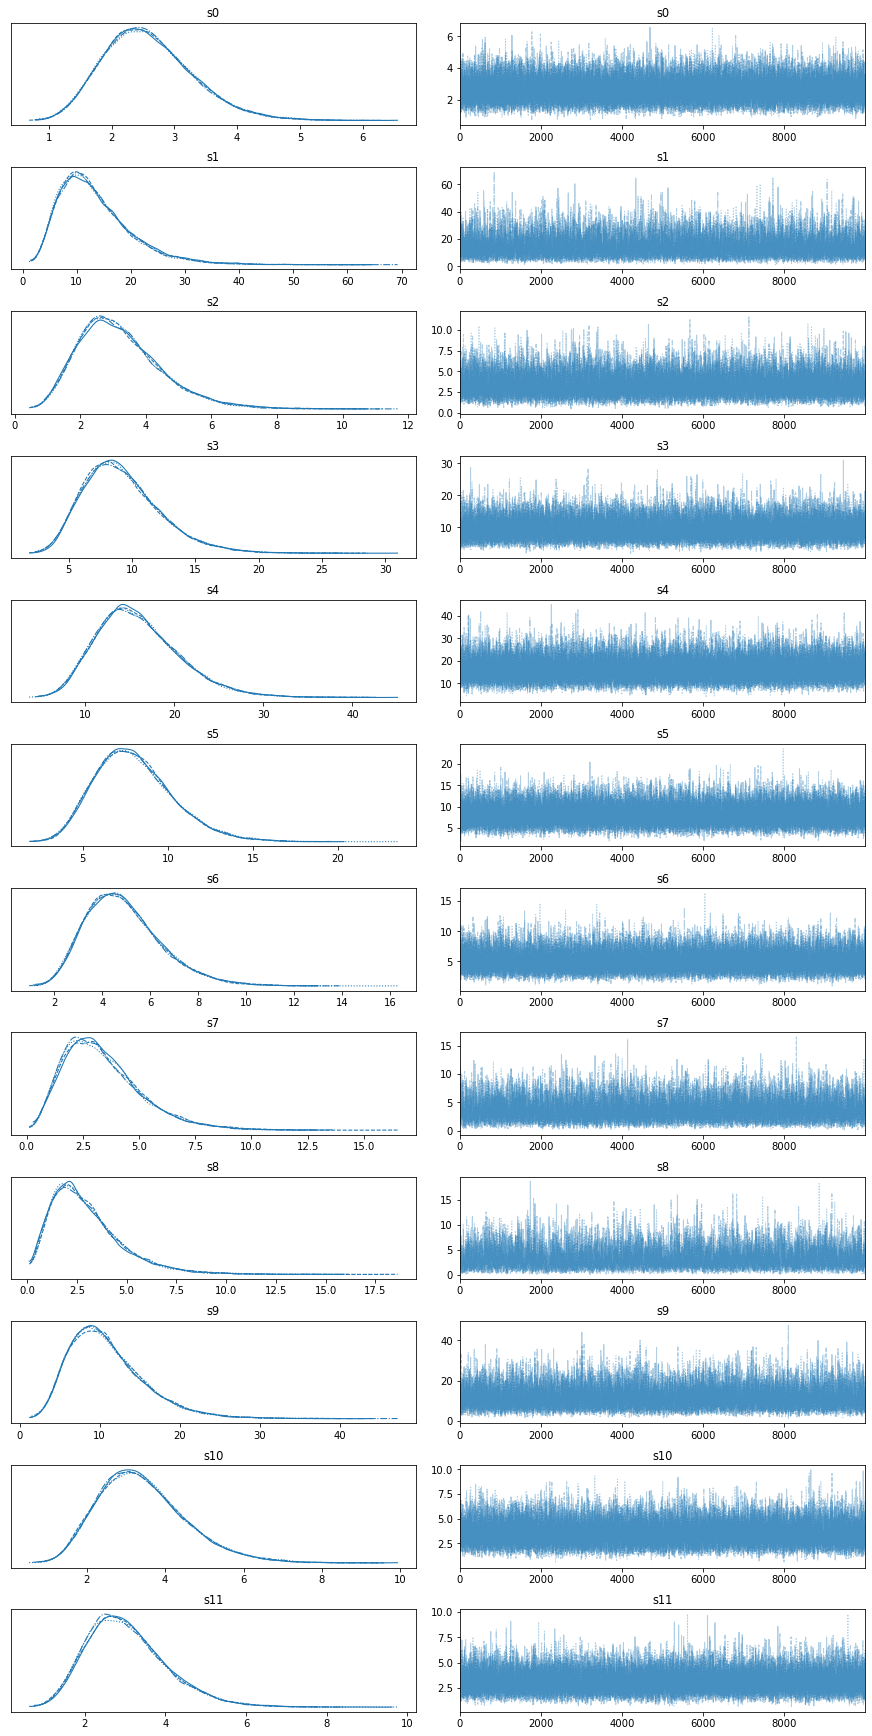

In [157]:
az.plot_trace(trace, var_names=["s0", "s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8", "s9", "s10", "s11"])

/Users/diegozertuche/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

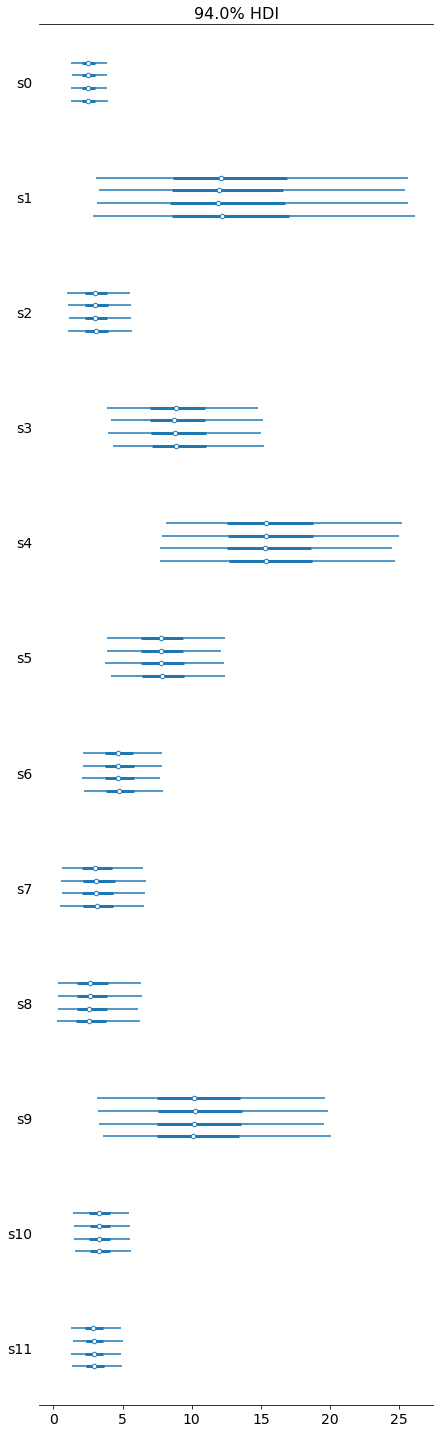

In [160]:
az.plot_forest(trace, var_names=["s0", "s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8", "s9", "s10", "s11"])

### FIN